<a href="https://colab.research.google.com/github/Gilangp/Machine-learning/blob/main/Model%20Klasifikasi%20Keutuhan%20Sayur/model_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Klasifikasi Keutuhan Sayur (Utuh/Tidak Utuh)**

### **Import Library**

In [ ]:
import subprocess
import sys

packages = ['tensorflow', 'scikit-image', 'tqdm', 'pandas', 'opencv-python', 'seaborn', 'pillow', 'joblib']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("All packages installed successfully")


All packages installed successfully


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from skimage.color import rgb2hsv, hsv2rgb
from skimage import exposure

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

from google.colab import drive
drive.mount('/content/drive')

print("Imports OK - TensorFlow:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imports OK - TensorFlow: 2.19.0


### **Load Dataset (Utuh/Tidak Utuh)**

In [ ]:
# DATASET_TRAIN = r"D:\KULIAH 5\PBL\dataset\train"
# DATASET_TEST = r"D:\KULIAH 5\PBL\dataset\test"

DATASET_TRAIN = r"/content/drive/MyDrive/Colab Notebooks/dataset/train"
DATASET_TEST = r"/content/drive/MyDrive/Colab Notebooks/dataset/test"

print("DATASET_TRAIN:", DATASET_TRAIN)

categories = ['utuh', 'tidak_utuh']
for cat in categories:
    path = os.path.join(DATASET_TRAIN, cat)
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    print(f"{cat}: {count} images")

print("\nDATASET_TEST:", DATASET_TEST)

categories = ['utuh', 'tidak_utuh']
for cat in categories:
    path = os.path.join(DATASET_TEST, cat)
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    print(f"{cat}: {count} images")

DATASET_TRAIN: /content/drive/MyDrive/Colab Notebooks/dataset/train
utuh: 600 images
tidak_utuh: 600 images

DATASET_TEST: /content/drive/MyDrive/Colab Notebooks/dataset/test
utuh: 120 images
tidak_utuh: 120 images


### **Pre-processing**

In [ ]:
def preprocess_image(image):
    # 1. Resize ke 224 × 224
    image = cv2.resize(image, (224, 224))

    #2. BGR → RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi awal 0-1
    img = image.astype(np.float32) / 255.0

    # 4. Brightness & Contrast Adjustment
    img_tf = tf.constant(img)

    brightness_delta = 0.1
    img_tf = tf.image.adjust_brightness(img_tf, brightness_delta)

    contrast_factor = 1.3
    img_tf = tf.image.adjust_contrast(img_tf, contrast_factor)

    img = img_tf.numpy()
    img = np.clip(img, 0, 1)

    # 5. Histogram Equalization pada Kanal V (HSV)
    img_hsv = rgb2hsv(img)
    v_channel = img_hsv[:, :, 2]
    v_channel_eq = exposure.equalize_adapthist(v_channel)
    img_hsv[:, :, 2] = v_channel_eq
    img = hsv2rgb(img_hsv)

    # 6. Saturation Enhancement
    img_hsv_final = rgb2hsv(img)
    saturation_boost = 1.2
    img_hsv_final[:, :, 1] = np.clip(img_hsv_final[:, :, 1] * saturation_boost, 0, 1)
    img = hsv2rgb(img_hsv_final)

    return np.clip(img, 0, 1).astype(np.float32)

In [ ]:
# load dan preprocess train data
train_images = []
train_labels = []

print("Loading and preprocessing training data...")
for cat_idx, cat in enumerate(categories):
    cat_path = os.path.join(DATASET_TRAIN, cat)
    files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    for file in tqdm(files, desc=f"Processing {cat}"):
        try:
            img_path = os.path.join(cat_path, file)
            img = cv2.imread(img_path)

            img_processed = preprocess_image(img)

            train_images.append(img_processed)
            train_labels.append(cat_idx)
        except Exception as e:
            print(f"Error loading {file}: {e}")

# load dan preprocess test data
test_images = []
test_labels = []

print("\nLoading and preprocessing test data...")
for cat_idx, cat in enumerate(categories):
    cat_path = os.path.join(DATASET_TEST, cat)
    files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    for file in tqdm(files, desc=f"Processing {cat}"):
        try:
            img_path = os.path.join(cat_path, file)
            img = cv2.imread(img_path)

            img_processed = preprocess_image(img)

            test_images.append(img_processed)
            test_labels.append(cat_idx)
        except Exception as e:
            print(f"Error loading {file}: {e}")

# convert to numpy arrays
X_train = np.array(train_images, dtype=np.float32)
y_train = np.array(train_labels, dtype=np.int32)

X_test = np.array(test_images, dtype=np.float32)
y_test = np.array(test_labels, dtype=np.int32)

# shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print(f"\nTraining data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

Loading and preprocessing training data...


Processing tidak_utuh: 100%|██████████| 600/600 [00:38<00:00, 15.71it/s]



Loading and preprocessing test data...


Processing tidak_utuh: 100%|██████████| 120/120 [00:06<00:00, 17.46it/s]



Training data shape: (1200, 224, 224, 3), Labels: (1200,)
Test data shape: (240, 224, 224, 3), Labels: (240,)
Class distribution - Train: [600 600], Test: [120 120]


### **Feature Extraction**
Ekstraksi fitur menggunakan arsitektur MobileNetV2 pretrained (ImageNet):
- Layer awal (Low-Level Features): menangkap edge, garis, tekstur dasar, dan pola frekuensi rendah
- Layer tengah (Mid-Level Features): menangkap pola permukaan, warna, tekstur kompleks, dan bayangan
- Layer akhir (High-Level Features): menangkap bentuk global, struktur objek, dan pola kerusakan fisik

In [ ]:
def build_feature_extractor():
    mobilenet_backbone = keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )

    mobilenet_backbone.trainable = False
    return mobilenet_backbone

feature_extractor = build_feature_extractor()

### **Classification Model dengan Dense Layers & Softmax**
- Backbone: MobileNetV2 (frozen)
- Feature Reduction Block: Dense layers dengan ReLU activation
- Batch Normalization: mempercepat konvergensi
- Dropout layers: mencegah overfitting
- Softmax (Utuh / Tidak Utuh)

In [ ]:
def classifier_model():
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),

        # Feature Extraction dari Low → Mid → High
        feature_extractor,

        # kurangi 1280 fitur menjadi 256 dimensi dengan aktivasi ReLU
        layers.Dense(256, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001),
                    name='dense_256'),
        # normalisasi aktivasi untuk konvergensi lebih cepat dan stabil
        layers.BatchNormalization(name='bn_256'),
        # singkirkan 50% neuron secara acak
        layers.Dropout(0.5, name='dropout_0.5'),

        # 128 dimensi untuk klasifikasi biner
        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001),
                    name='dense_128'),
        # normalisasi sebelum layer klasifikasi akhir
        layers.BatchNormalization(name='bn_128'),
        # singkirkan 40% neuron untuk mempertahankan regularisasi
        layers.Dropout(0.4, name='dropout_0.4'),

        # output klasifikasi biner dengan probabilitas softmax
        layers.Dense(2, activation='softmax', name='output')
    ])

    return model

### **Build Model**

In [ ]:
print("Building model with MobileNetV2 feature extraction...")
model = classifier_model()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Building model with MobileNetV2 feature extraction...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_256 (BatchNormalization)     │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0.5 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_128 (BatchNormalization)     │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0.4 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,610 (10.00 MB)

 Trainable params: 361,858 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

### **Model Training**
- Epochs: 30 atau sampai early stopping
- Batch size: 32 samples per batch
- Validation split: 20% dari training data
- Early Stopping: Monitor val_loss dengan patience=5
- ReduceLROnPlateau: Turunkan learning rate jika val_loss plateau

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.6525 - loss: 1.3820 - val_accuracy: 0.7417 - val_loss: 1.0435 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8190 - loss: 1.0017 - val_accuracy: 0.9250 - val_loss: 0.8287 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8818 - loss: 0.8843 - val_accuracy: 0.9458 - val_loss: 0.7427 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9194 - loss: 0.8027 - val_accuracy: 0.9583 - val_loss: 0.7155 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9485 - loss: 0.7353 - val_accuracy: 0.9583 - val_loss: 0.7041 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9477 - loss: 0.7289 - val_accuracy: 0.9625 - val_loss: 0.6954 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.973

### **Training History Visualization**
- Accuracy curve: Train vs Validation
- Loss curve: Train vs Validation
- Deteksi overfitting: Gap antara train dan validation
- Best epoch: Epoch dengan validation loss terendah

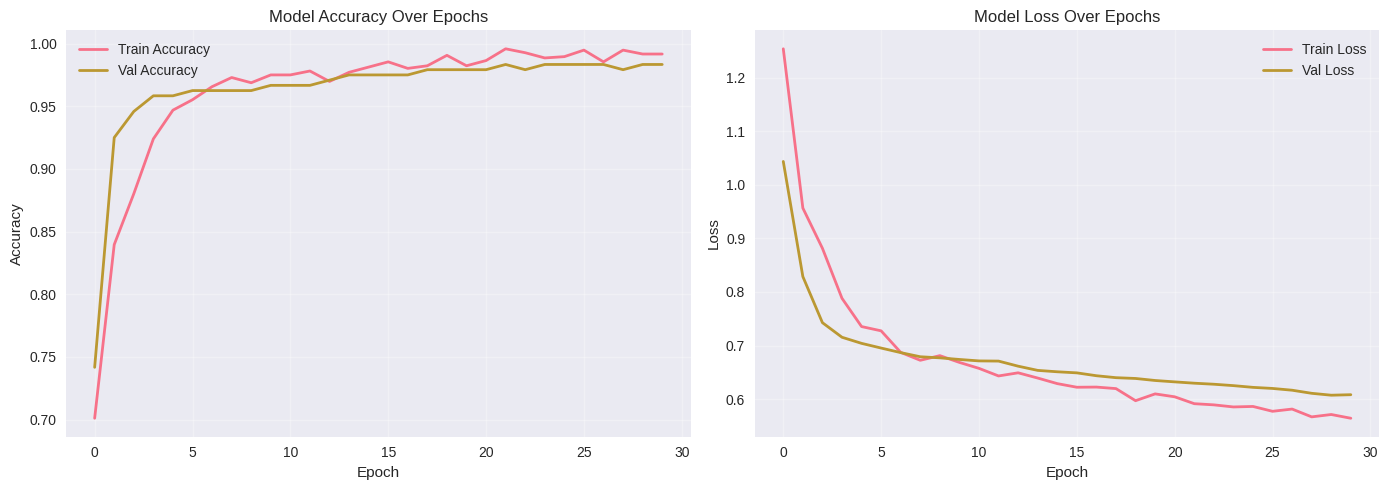

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('PBL/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# deteksi overfitting - Gap antara train dan validation
print("\n" + "="*60)
print("OVERFITTING DETECTION - ACCURACY & LOSS GAP")
print("="*60)

train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
acc_gap = abs(train_acc_final - val_acc_final)

train_loss_final = history.history['loss'][-1]
val_loss_final = history.history['val_loss'][-1]
loss_gap = abs(train_loss_final - val_loss_final)

print(f"\nAccuracy Gap:")
print(f"  Train Accuracy: {train_acc_final:.4f}")
print(f"  Val Accuracy:   {val_acc_final:.4f}")
print(f"  Gap: {acc_gap:.4f} ({acc_gap*100:.2f}%)")

print(f"\nLoss Gap:")
print(f"  Train Loss: {train_loss_final:.4f}")
print(f"  Val Loss:   {val_loss_final:.4f}")
print(f"  Gap: {loss_gap:.4f}")

# Interpretasi overfitting
if acc_gap > 0.15:
    print(f"\nWARNING: Strong overfitting detected (gap > 15%)")
elif acc_gap > 0.05:
    print(f"\nCAUTION: Mild overfitting (gap 5-15%)")
else:
    print(f"\n✓ GOOD: Minimal overfitting (gap < 5%)")


OVERFITTING DETECTION - ACCURACY & LOSS GAP

Accuracy Gap:
  Train Accuracy: 0.9917
  Val Accuracy:   0.9833
  Gap: 0.0083 (0.83%)

Loss Gap:
  Train Loss: 0.5644
  Val Loss:   0.6083
  Gap: 0.0439

✓ GOOD: Minimal overfitting (gap < 5%)


In [ ]:
# best epoch - epoch dengan validation loss terendah
print("\n" + "="*60)
print("BEST EPOCH ANALYSIS")
print("="*60)

best_epoch_idx = np.argmin(history.history['val_loss'])
best_epoch = best_epoch_idx + 1

best_val_loss = history.history['val_loss'][best_epoch_idx]
best_train_loss = history.history['loss'][best_epoch_idx]
best_val_acc = history.history['val_accuracy'][best_epoch_idx]
best_train_acc = history.history['accuracy'][best_epoch_idx]

print(f"\nBest Epoch: {best_epoch}")
print(f"  Validation Loss: {best_val_loss:.4f} (lowest)")
print(f"  Training Loss:   {best_train_loss:.4f}")
print(f"  Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Training Accuracy:   {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")

print(f"\n✓ Model checkpoint saved at epoch {best_epoch} with best validation loss")


BEST EPOCH ANALYSIS

Best Epoch: 29
  Validation Loss: 0.6074 (lowest)
  Training Loss:   0.5714
  Validation Accuracy: 0.9833 (98.33%)
  Training Accuracy:   0.9917 (99.17%)

✓ Model checkpoint saved at epoch 29 with best validation loss


### **Model Evaluation & Metrics**
Evaluasi pada train set dan test set:
- Train Loss & Train Accuracy
- Test Loss & Test Accuracy
- Precision - Dari prediksi positif, berapa yang benar?
- Recall - Dari yang seharusnya positif, berapa yang terdeteksi?
- F1-Score - Harmonic mean dari precision dan recall
- Classification Report - Per-class breakdown

In [ ]:
# evaluasi pada train set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)

print("\n" + "="*60)
print("TRAIN SET PERFORMANCE")
print("="*60)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Prediksi pada train set untuk metrik detail
y_pred_train = model.predict(X_train, verbose=0)
y_pred_train_labels = np.argmax(y_pred_train, axis=1)

train_accuracy_detail = accuracy_score(y_train, y_pred_train_labels)
train_precision = precision_score(y_train, y_pred_train_labels, average='weighted')
train_recall = recall_score(y_train, y_pred_train_labels, average='weighted')
train_f1 = f1_score(y_train, y_pred_train_labels, average='weighted')

print("\nDetailed Metrics (Train):")
print(f"Accuracy:  {train_accuracy_detail:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")
print("="*60)

print("\nClassification Report (Train Set):")
print(classification_report(y_train, y_pred_train_labels, target_names=categories))


TRAIN SET PERFORMANCE
Train Loss: 0.5589
Train Accuracy: 0.9967 (99.67%)

Detailed Metrics (Train):
Accuracy:  0.9967
Precision: 0.9967
Recall:    0.9967
F1-Score:  0.9967

Classification Report (Train Set):
              precision    recall  f1-score   support

        utuh       1.00      1.00      1.00       600
  tidak_utuh       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [ ]:
# evaluasi pada test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Prediksi pada test set
y_pred = model.predict(X_test, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("\nDetailed Metrics (Test):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_labels, target_names=categories))


TEST SET PERFORMANCE
Test Loss: 0.9116
Test Accuracy: 0.8833 (88.33%)

Detailed Metrics (Test):
Accuracy:  0.8833
Precision: 0.8943
Recall:    0.8833
F1-Score:  0.8825

Classification Report (Test Set):
              precision    recall  f1-score   support

        utuh       0.83      0.97      0.89       120
  tidak_utuh       0.96      0.80      0.87       120

    accuracy                           0.88       240
   macro avg       0.89      0.88      0.88       240
weighted avg       0.89      0.88      0.88       240



### **Confusion Matrix & Classification Analysis**
Analisis performa per class dengan confusion matrix heatmap:
- True Positives (TP): Correctly identified utuh/tidak_utuh
- False Positives (FP): Incorrectly labeled as utuh/tidak_utuh
- False Negatives (FN): Missed detections
- True Negatives (TN): Correctly rejected

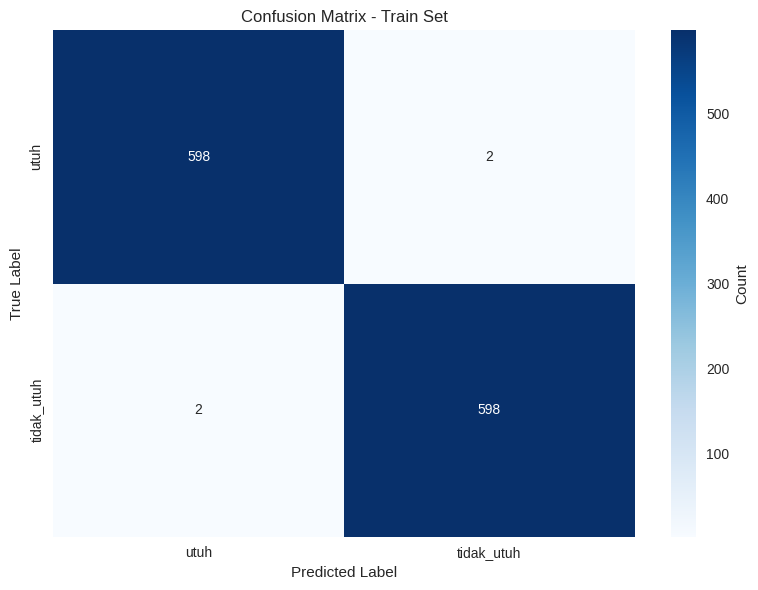

In [ ]:
# Confusion matrix untuk train set
cm_train = confusion_matrix(y_pred_train_labels, y_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Train Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
# plt.savefig('confusion_matrix_train.png', dpi=150, bbox_inches='tight')
plt.show()

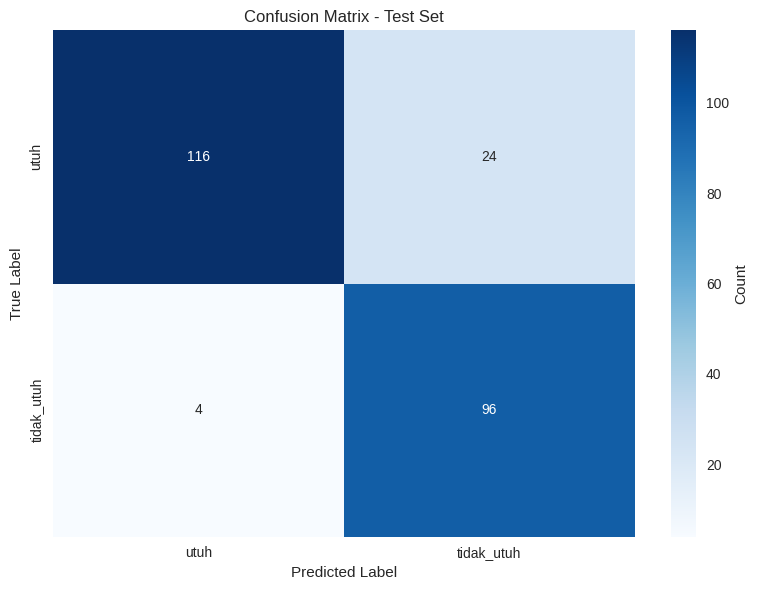

In [ ]:
# Confusion matrix untuk test set
cm_test = confusion_matrix(y_pred_labels, y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
# plt.savefig('confusion_matrix_test.png', dpi=150, bbox_inches='tight')
plt.show()

### **Deep Diagnostics - Model Analysis**
Analisis mendalam detail performa model per kategori:
- Per-class accuracy: Breakdown akurasi masing-masing kategori
- Confidence score distribution: Mean, median, range prediksi confidence
- Per-class confusion matrix breakdown: TP/FP/FN/TN detail per kategori

In [ ]:
print("\n" + "="*70)
print("PER-CLASS ACCURACY & CONFIDENCE ANALYSIS")
print("="*70)

# 1. Per-class accuracy pada test set
print("\n1. PER-CLASS ACCURACY (Test Set):")
utuh_mask = y_test == 0
tidak_utuh_mask = y_test == 1

utuh_correct = np.sum((y_pred_labels == 0) & utuh_mask)
tidak_utuh_correct = np.sum((y_pred_labels == 1) & tidak_utuh_mask)

utuh_acc = utuh_correct / np.sum(utuh_mask) if np.sum(utuh_mask) > 0 else 0
tidak_utuh_acc = tidak_utuh_correct / np.sum(tidak_utuh_mask) if np.sum(tidak_utuh_mask) > 0 else 0

print(f"   Utuh: {utuh_correct}/{np.sum(utuh_mask)} correct = {utuh_acc:.4f} ({utuh_acc*100:.2f}%)")
print(f"   Tidak Utuh: {tidak_utuh_correct}/{np.sum(tidak_utuh_mask)} correct = {tidak_utuh_acc:.4f} ({tidak_utuh_acc*100:.2f}%)")

# 2. Confidence score analysis
y_pred_all = model.predict(X_test, verbose=0)
confidences = np.max(y_pred_all, axis=1)

print("\n2. CONFIDENCE SCORE DISTRIBUTION (Test Set):")
print(f"   Mean:   {np.mean(confidences):.4f}")
print(f"   Median: {np.median(confidences):.4f}")
print(f"   Min:    {np.min(confidences):.4f}")
print(f"   Max:    {np.max(confidences):.4f}")
print(f"   Std:    {np.std(confidences):.4f}")

# 3. Per-class confusion matrix breakdown
print("\n3. CONFUSION MATRIX BREAKDOWN (Test Set):")
cm = confusion_matrix(y_pred_labels, y_test)
print(f"   Class 'Utuh':")
print(f"      TP (correct): {cm[0,0]}")
print(f"      FP (false positive): {cm[0,1]}")
print(f"   Class 'Tidak Utuh':")
print(f"      TP (correct): {cm[1,1]}")
print(f"      FN (false negative): {cm[1,0]}")


PER-CLASS ACCURACY & CONFIDENCE ANALYSIS

1. PER-CLASS ACCURACY (Test Set):
   Utuh: 116/120 correct = 0.9667 (96.67%)
   Tidak Utuh: 96/120 correct = 0.8000 (80.00%)

2. CONFIDENCE SCORE DISTRIBUTION (Test Set):
   Mean:   0.9344
   Median: 0.9959
   Min:    0.5171
   Max:    1.0000
   Std:    0.1179

3. CONFUSION MATRIX BREAKDOWN (Test Set):
   Class 'Utuh':
      TP (correct): 116
      FP (false positive): 24
   Class 'Tidak Utuh':
      TP (correct): 96
      FN (false negative): 4


### **Model Export & Deployment**
Simpan model ke format Keras dan H5:
- **Format**: Keras model (.keras) dan H5 (.h5)
- **Location**: `PBL/models/` directory

In [ ]:
os.makedirs('PBL1/models', exist_ok=True)

print("="*80)
print("MODEL EXPORT")
print("="*80)

model.save('PBL1/models/model_mobilenetv2_classifier.keras')
print("✓ Model saved as: PBL1/models/model_mobilenetv2_classifier.keras")

model.save('PBL1/models/model_mobilenetv2_classifier.h5')
print("✓ Model saved as: PBL1/models/model_mobilenetv2_classifier.h5")
print("\nMODEL INFORMATION")
print("-"*80)

keras_size = os.path.getsize('PBL1/models/model_mobilenetv2_classifier.keras') / (1024 * 1024)
h5_size = os.path.getsize('PBL1/models/model_mobilenetv2_classifier.h5') / (1024 * 1024)

print(f"Keras model size: {keras_size:.2f} MB")
print(f"H5 model size: {h5_size:.2f} MB")

MODEL EXPORT


✓ Model saved as: PBL1/models/model_mobilenetv2_classifier.keras
✓ Model saved as: PBL1/models/model_mobilenetv2_classifier.h5

MODEL INFORMATION
--------------------------------------------------------------------------------
Keras model size: 13.34 MB
H5 model size: 13.13 MB
